<a href="https://colab.research.google.com/github/acv0209/DKUBigData/blob/master/bigdata_colab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Keras를 이용하여 MNIST AutoEncoder 구현하기

---


In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

input_img = Input(shape=(28, 28, 1))

Using TensorFlow backend.


In [0]:
#Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

#Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 146us/step - loss: 0.2187 - val_loss: 0.1651
Epoch 2/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.1572 - val_loss: 0.1481
Epoch 3/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.1423 - val_loss: 0.1342
Epoch 4/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.1342 - val_loss: 0.1308
Epoch 5/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.1285 - val_loss: 0.1217
Epoch 6/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.1242 - val_loss: 0.1215
Epoch 7/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.1214 - val_loss: 0.1151
Epoch 8/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.1189 - val_loss: 0.1166
Epoch 9/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.1172 - val_loss: 0.1

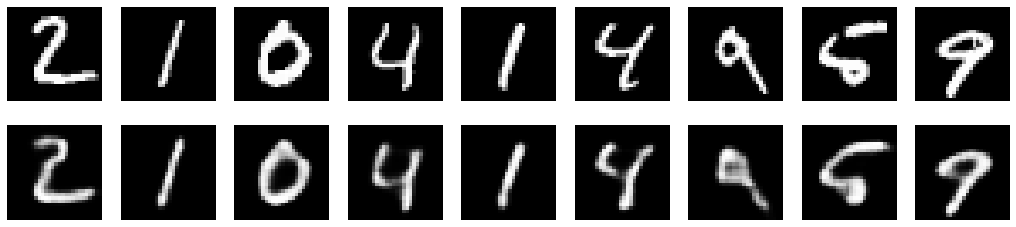

In [5]:
# visualize trained autoencoder
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 5. Keras를 이용하여 MNIST GAN 구현하기

---


In [0]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random
#from tqdm import tqdm_notebook

In [0]:

# 데이터 전처리
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [9]:
# Generator

z_dim = 100
nch = 200

adam = Adam(lr=0.0002, beta_1=0.5)

g = Sequential()
g.add(Dense(7*7*112, input_dim=z_dim))
g.add(Reshape((7, 7, 112)))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(56, 5, strides=2, padding='same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
g.add(Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid'))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
#g.summary()

d = Sequential()
d.add(Conv2D(56, 5, strides=2, padding='same', input_shape=(28, 28, 1), activation=LeakyReLU(alpha=0.2)))
d.add(Conv2D(112, 5, strides=2, padding='same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Conv2D(224, 5, strides=2, padding='same'))
g.add(Activation(LeakyReLU(alpha=0.2)))
d.add(Flatten())
d.add(Dense(112, activation=LeakyReLU(alpha=0.2)))
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
#d.summary()

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
#gan.summary()

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(generated_images.shape[0], 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}
samples = []

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in range(1, epochs+1):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            image_batch = image_batch.reshape(image_batch.shape[0], image_batch.shape[1], image_batch.shape[2], 1)
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            samples.append(generated_images)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


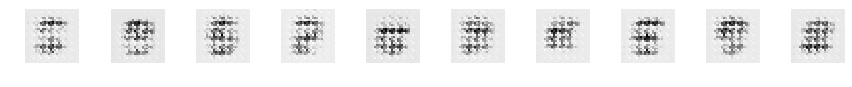

--------------- Epoch 2 ---------------


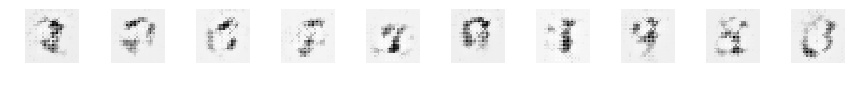

--------------- Epoch 3 ---------------


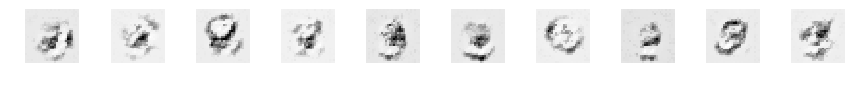

--------------- Epoch 4 ---------------


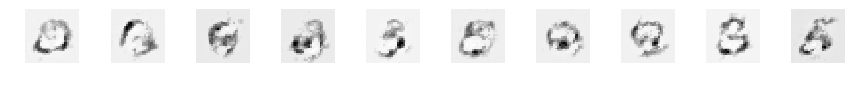

--------------- Epoch 5 ---------------


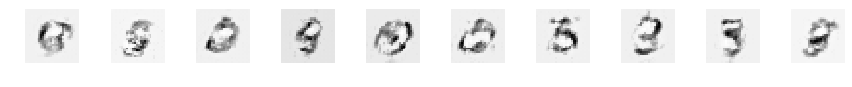

--------------- Epoch 6 ---------------


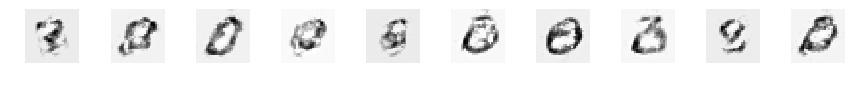

--------------- Epoch 7 ---------------


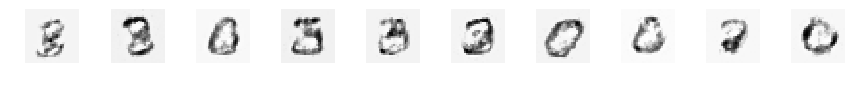

--------------- Epoch 8 ---------------


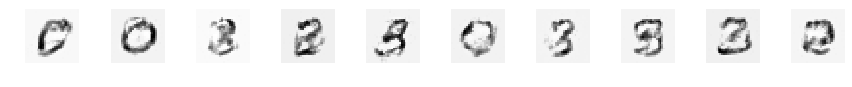

--------------- Epoch 9 ---------------


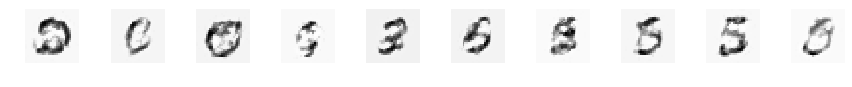

--------------- Epoch 10 ---------------


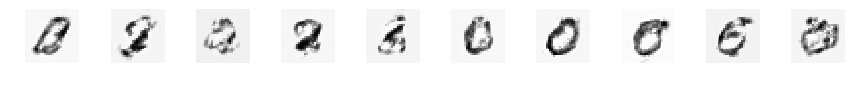

--------------- Epoch 11 ---------------


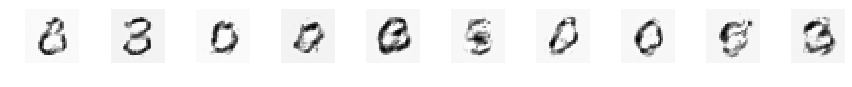

--------------- Epoch 12 ---------------


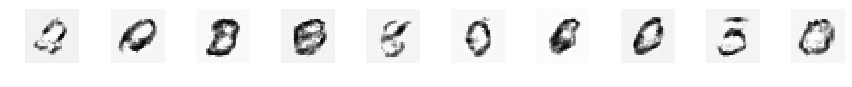

--------------- Epoch 13 ---------------


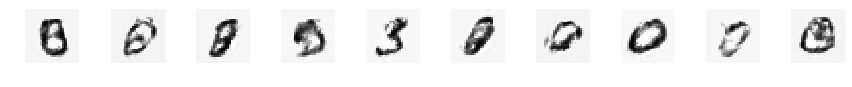

--------------- Epoch 14 ---------------


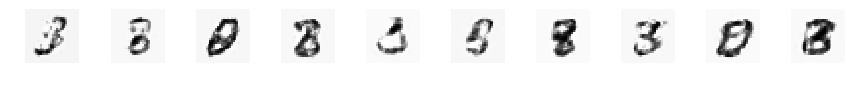

--------------- Epoch 15 ---------------


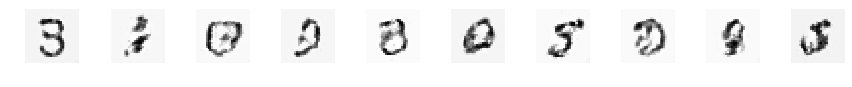

--------------- Epoch 16 ---------------


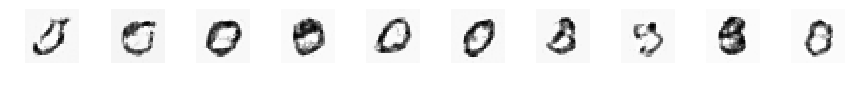

--------------- Epoch 17 ---------------


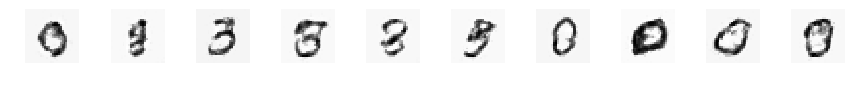

--------------- Epoch 18 ---------------


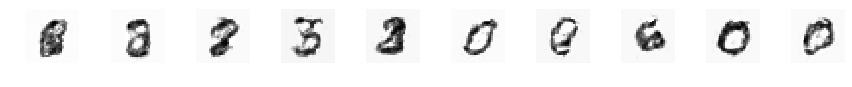

--------------- Epoch 19 ---------------


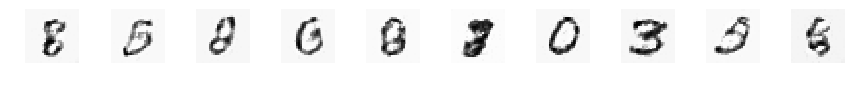

--------------- Epoch 20 ---------------


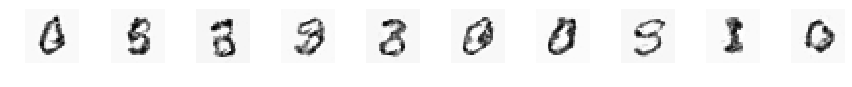

--------------- Epoch 21 ---------------


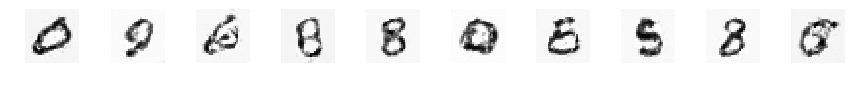

--------------- Epoch 22 ---------------


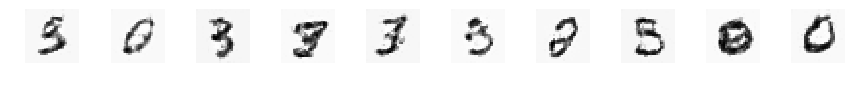

--------------- Epoch 23 ---------------


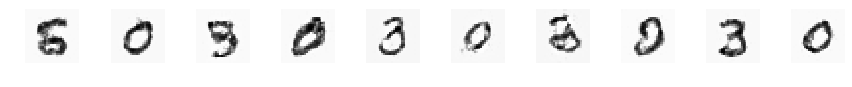

--------------- Epoch 24 ---------------


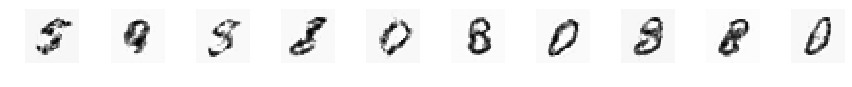

--------------- Epoch 25 ---------------


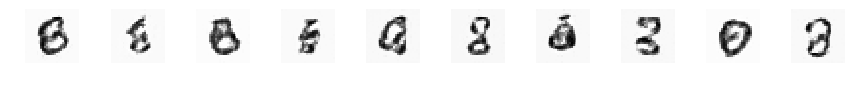

--------------- Epoch 26 ---------------


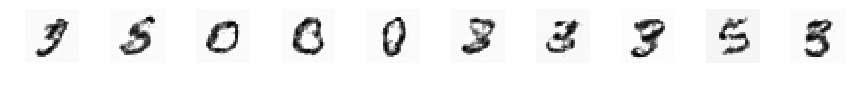

--------------- Epoch 27 ---------------


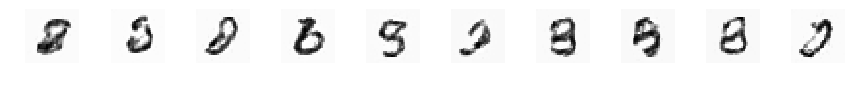

--------------- Epoch 28 ---------------


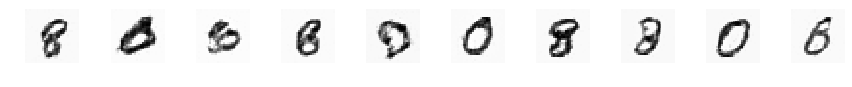

--------------- Epoch 29 ---------------


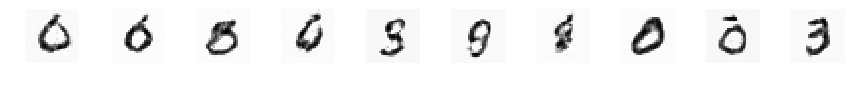

--------------- Epoch 30 ---------------


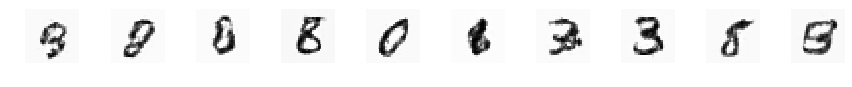

--------------- Epoch 31 ---------------


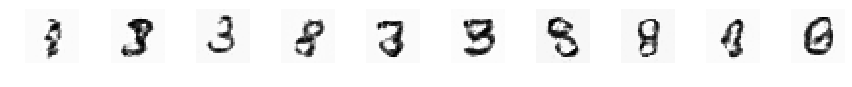

--------------- Epoch 32 ---------------


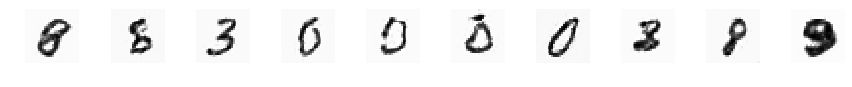

--------------- Epoch 33 ---------------


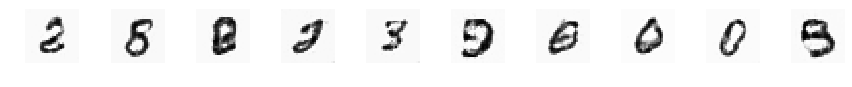

--------------- Epoch 34 ---------------


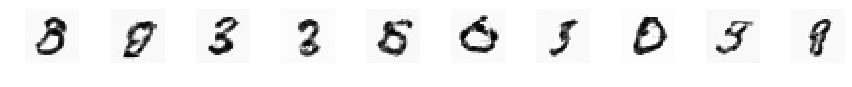

--------------- Epoch 35 ---------------


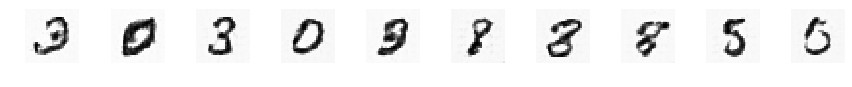

--------------- Epoch 36 ---------------


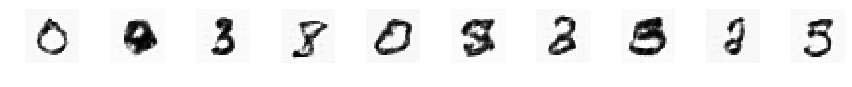

--------------- Epoch 37 ---------------


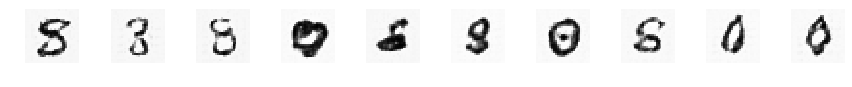

--------------- Epoch 38 ---------------


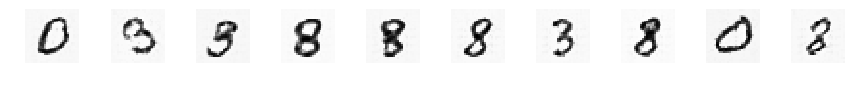

--------------- Epoch 39 ---------------


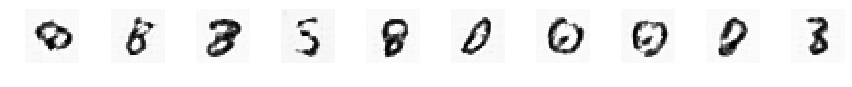

--------------- Epoch 40 ---------------


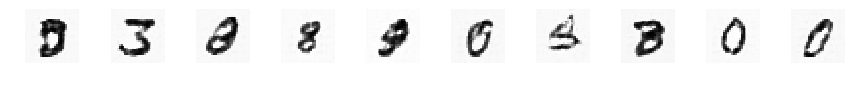

--------------- Epoch 41 ---------------


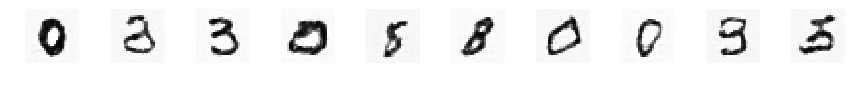

--------------- Epoch 42 ---------------


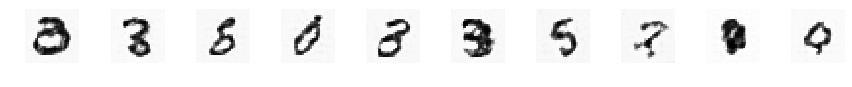

--------------- Epoch 43 ---------------


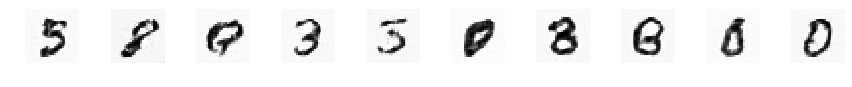

--------------- Epoch 44 ---------------


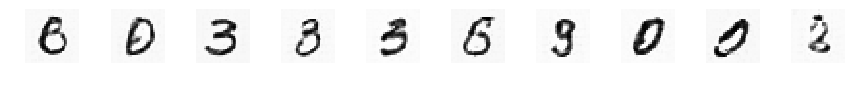

--------------- Epoch 45 ---------------


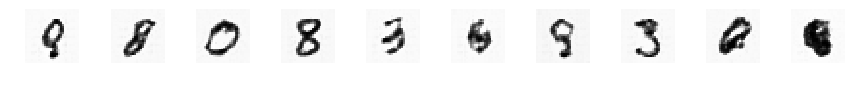

--------------- Epoch 46 ---------------


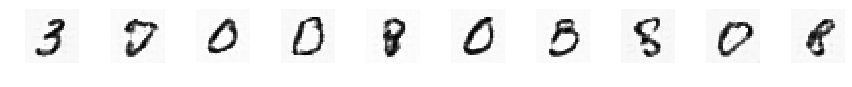

--------------- Epoch 47 ---------------


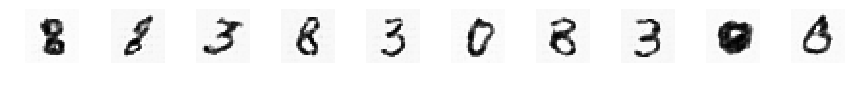

--------------- Epoch 48 ---------------


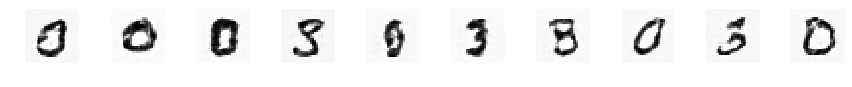

--------------- Epoch 49 ---------------


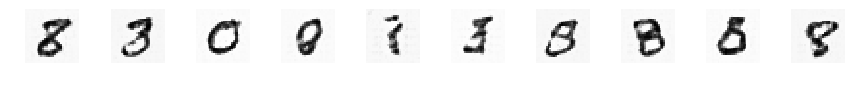

--------------- Epoch 50 ---------------


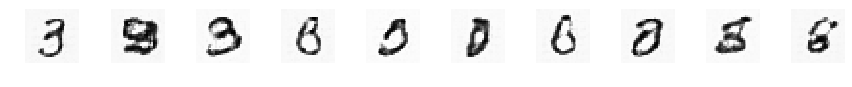

--------------- Epoch 51 ---------------


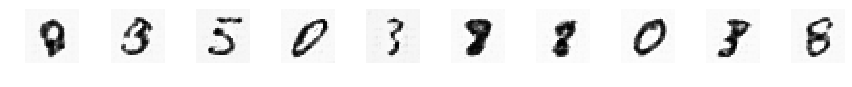

--------------- Epoch 52 ---------------


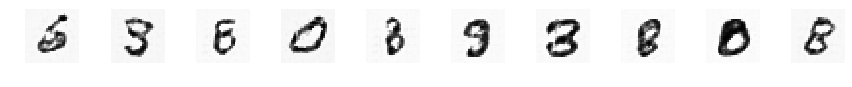

--------------- Epoch 53 ---------------


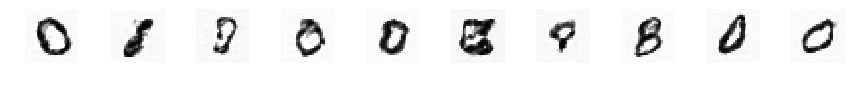

--------------- Epoch 54 ---------------


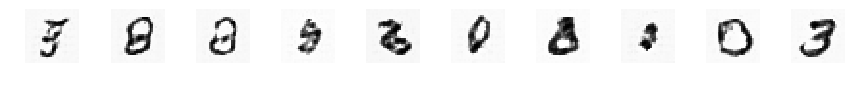

--------------- Epoch 55 ---------------


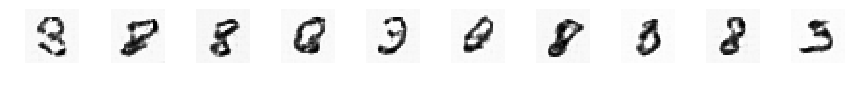

--------------- Epoch 56 ---------------


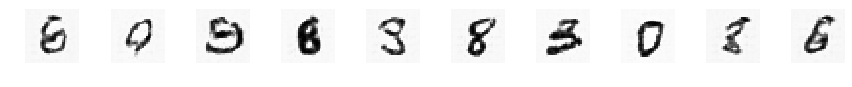

--------------- Epoch 57 ---------------


In [0]:
train(epochs=200, plt_frq=1, BATCH_SIZE=128)
